In [1]:
# 1. IMPORTS & SETUP
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay,
    accuracy_score
)
from sklearn.model_selection import KFold
from sklearn.base import clone

In [2]:
# Define cohort
cohort = "mimic_cohort_NF_30_days"

# LOAD DATA
try:
    # Load Target Labels
    target = pd.read_csv(f"../data/{cohort}/{cohort}.csv.gz", compression="gzip", index_col=0)
    
    # Load 'Up To' ICD Codes
    icd_codes_data = pd.read_csv(f"../data/{cohort}/{cohort}_icd_codes_upto.csv.gz", compression="gzip", index_col=0)   
    print("Files loaded successfully.")
except FileNotFoundError:
    print("Error: Files not found. Check paths.")

# Preprocessing: Create Groups
icd_codes_data["icd_code_group"] = icd_codes_data["icd_code"].str[:3]
icd_codes_data = icd_codes_data.merge(
    target[["hadm_id", "age", "gender"]],
    on=["subject_id", "hadm_id"],
    how="left")
display(icd_codes_data)

Files loaded successfully.


,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,icd_code_group,age,gender
0,10010231,23835132,1,K2960,10,Other gastritis without bleeding,K29,57.0,M
1,10010231,23835132,2,D61810,10,Antineoplastic chemotherapy induced pancytopenia,D61,57.0,M
2,10010231,23835132,3,C92Z0,10,Other myeloid leukemia not having achieved rem...,C92,57.0,M
3,10010231,23835132,4,K219,10,Gastro-esophageal reflux disease without esoph...,K21,57.0,M
4,10010231,23835132,5,E860,10,Dehydration,E86,57.0,M
...,...,...,...,...,...,...,...,...,...
406259,19999784,25127296,5,Z8619,10,Personal history of other infectious and paras...,Z86,57.0,M
406260,19999784,25989171,5,Z8619,10,Personal history of other infectious and paras...,Z86,57.0,M
406261,19999784,27302283,5,Z8619,10,Personal history of other infectious and paras...,Z86,57.0,M
406262,19999784,27773137,5,Z8619,10,Personal history of other infectious and paras...,Z86,57.0,M


In [3]:
# 3. FEATURE ENGINEERING (Full, Groups, Combined)

# Create Full Codes Matrix
print("Generating X_full (Full Codes)...")
X_full = icd_codes_data.groupby(["hadm_id", "icd_code"]).size().unstack("icd_code").fillna(0).astype(int)
X_full = (X_full > 0).astype(int)

# Create Group Matrix
print("Generating X_groups (Code Groups)...")
X_groups = icd_codes_data.groupby(["hadm_id", "icd_code_group"]).size().unstack("icd_code_group").fillna(0).astype(int)
X_groups = (X_groups > 0).astype(int)

# Ensure X_groups has same rows/indices as X_full (align patients)
X_groups = X_groups.reindex(X_full.index, fill_value=0)

#Create Combined Matrix (Full+Groups)
print("Generating X_combined (Combined)...")
X_combined = pd.concat([X_full, X_groups], axis=1)

print(f"Dimensions -> Full: {X_full.shape}, Groups: {X_groups.shape}, Combined: {X_combined.shape}")

Generating X_full (Full Codes)...
Generating X_groups (Code Groups)...
Generating X_combined (Combined)...
Dimensions -> Full: (4539, 6952), Groups: (4539, 1683), Combined: (4539, 8635)


In [4]:
# DATA ALIGNMENT

# Index target data by hadm_id and find the intersection of IDs to align features (X_full) and targets for valid samples. 
target_indexed = target.set_index("hadm_id")
valid_ids = X_full.index.intersection(target_indexed.index)

# Filter all matrices to valid IDs
X_full = X_full.loc[valid_ids]
X_groups = X_groups.loc[valid_ids]
X_combined = X_combined.loc[valid_ids]
y_full = target_indexed.loc[valid_ids]["label"]


print(f"Valid (matching) hadm_ids: {len(valid_ids)}")
print("Label distribution:")
print(y_full.value_counts())

Valid (matching) hadm_ids: 4451
Label distribution:
label
0    4224
1     227
Name: count, dtype: int64


In [5]:
# 5. MODEL CONFIGURATION
models_config = {
    "XGBoost": XGBClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=6, eval_metric="logloss", n_jobs=-1, random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=10, class_weight="balanced", n_jobs=-1, random_state=42),
    "CatBoost": CatBoostClassifier(
        iterations=200, learning_rate=0.05, depth=6, verbose=0, allow_writing_files=False, random_state=42)
}

feature_datasets = {
    "Full Codes": X_full,
    "Groups": X_groups,
    "Combined": X_combined
}

In [6]:
# TRAINING & EVALUATION LOOP
# Creating folds dynamically on valid_ids
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_indices = list(kf.split(valid_ids))

results_data = []

for feat_name, X_data in feature_datasets.items():
    print(f"\n--- Processing Features: {feat_name} ---")
    
    for model_name, base_model in models_config.items():
        print(f"  Training {model_name}...", end=" ")        
        fold_auc = []
        
        for train_idx, test_idx in fold_indices:
            # Split Data
            X_train, X_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
            y_train, y_test = y_full.iloc[train_idx], y_full.iloc[test_idx]
            
            # Clone Model
            model = clone(base_model)
            
            # Handle Imbalance for Boosting
            if model_name in ["XGBoost", "CatBoost"]:
                ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
                model.set_params(scale_pos_weight=ratio)
            
            # Train & Predict
            model.fit(X_train, y_train)
            y_prob = model.predict_proba(X_test)[:, 1]
            
            fold_auc.append(roc_auc_score(y_test, y_prob))
            
        avg_auc = np.mean(fold_auc)
        print(f"-> Avg AUC: {avg_auc:.4f}")
        
        results_data.append({
            "Model": model_name,
            "Features": feat_name,
            "AUC": avg_auc
        })


--- Processing Features: Full Codes ---
  Training XGBoost... -> Avg AUC: 0.7817
  Training RandomForest... -> Avg AUC: 0.8072
  Training CatBoost... -> Avg AUC: 0.7996

--- Processing Features: Groups ---
  Training XGBoost... -> Avg AUC: 0.7731
  Training RandomForest... -> Avg AUC: 0.7960
  Training CatBoost... -> Avg AUC: 0.7867

--- Processing Features: Combined ---
  Training XGBoost... -> Avg AUC: 0.7767
  Training RandomForest... -> Avg AUC: 0.8069
  Training CatBoost... -> Avg AUC: 0.8060



Summary Results:


Features,Combined,Full Codes,Groups
Model,,,
CatBoost,0.805989,0.799607,0.786689
RandomForest,0.806950,0.807218,0.796049
XGBoost,0.776721,0.781677,0.773125


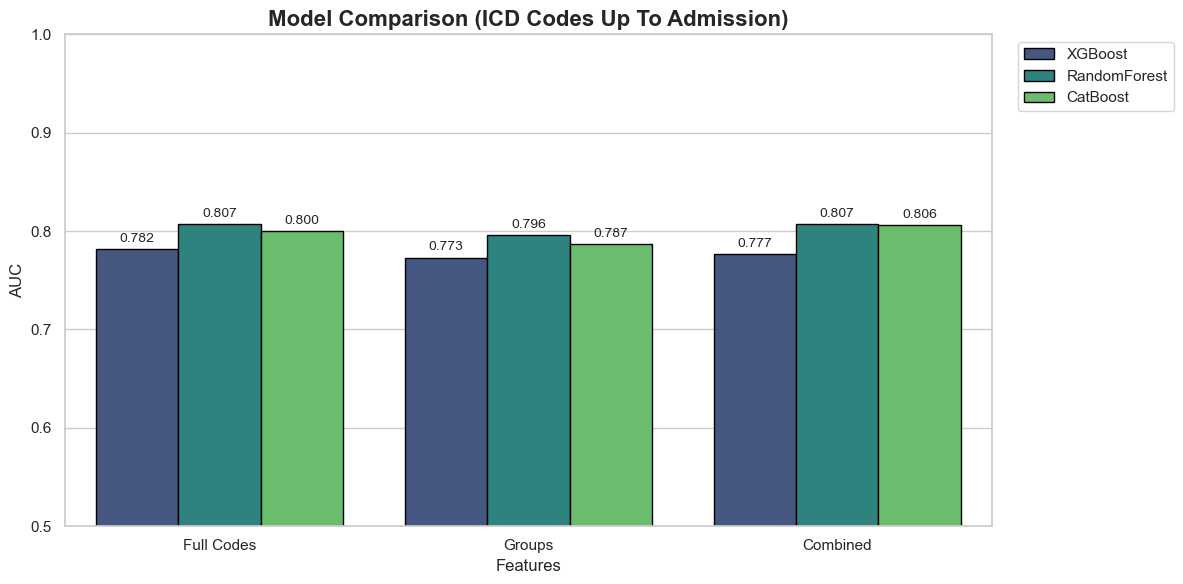

In [7]:
# Display Final Summary Table
summary_df = pd.DataFrame(results_data)
print("\nSummary Results:")
display(summary_df.pivot(index="Model", columns="Features", values="AUC"))

# Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=summary_df, x="Features", y="AUC", hue="Model", palette="viridis", edgecolor="black")
plt.title("Model Comparison (ICD Codes Up To Admission)", fontsize=16, fontweight='bold')
plt.ylim(0.5, 1.0)
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


--- Selecting Best Model Configuration ---
WINNER: RandomForest using Full Codes (AUC: 0.8072)

Aggregating CV Test Set Predictions
Aggregate AUC (on CV Test Folds): 0.8049


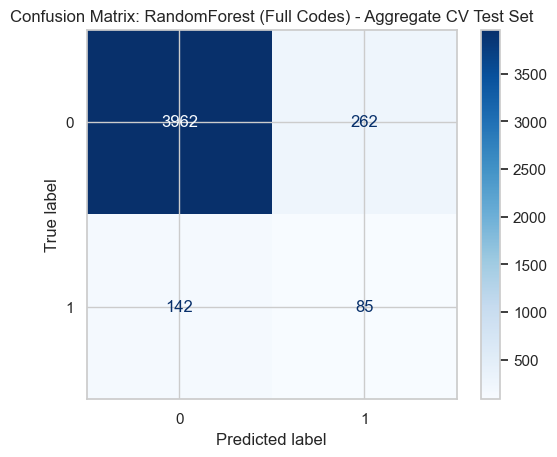

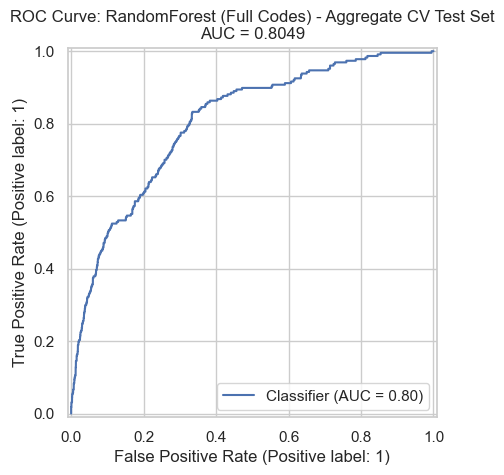

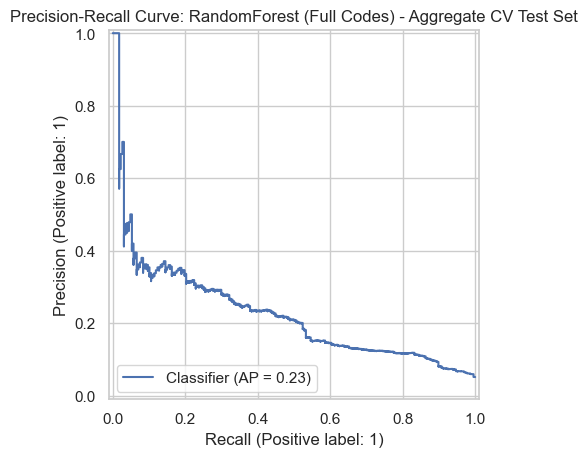

Model saved to: ../models/mimic_cohort_NF_30_days_icd_upto_RandomForest_Full_Codes_model.pkl


In [8]:
# Finding Best model
print("\n--- Selecting Best Model Configuration ---")
best_row = summary_df.loc[summary_df['AUC'].idxmax()]
best_model_name = best_row['Model']
best_features_name = best_row['Features']
best_auc = best_row['AUC']
print(f"WINNER: {best_model_name} using {best_features_name} (AUC: {best_row['AUC']:.4f})")

# Get the full feature matrix for the winner
if best_features_name == "Full Codes": X_final = X_full
elif best_features_name == "Groups": X_final = X_groups
elif best_features_name == "Combined": X_final = X_combined
else:
    raise ValueError("Feature set name not recognized for final training.")

y_final = y_full
# Instantiate and Configure Final Model
if best_model_name == "XGBoost":
    final_model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, eval_metric="logloss", n_jobs=-1, random_state=42)
elif best_model_name == "RandomForest":
    final_model = RandomForestClassifier(n_estimators=500, max_depth=10, class_weight="balanced", n_jobs=-1, random_state=42)
elif best_model_name == "CatBoost":
    final_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=0, allow_writing_files=False, random_state=42)

# Apply scale_pos_weight if it's a boosting model (using the full dataset ratio)
if best_model_name in ["XGBoost", "CatBoost"]:
    final_ratio = float(np.sum(y_final == 0)) / np.sum(y_final == 1)
    final_model.set_params(scale_pos_weight=final_ratio)

# Re-run CV for the WINNER to get AGGREGATE PLOTS (avoiding data leakage) 
print("\nAggregating CV Test Set Predictions")
X_data_for_cv = X_final 
y_data_for_cv = y_final

# Clone the base model parameters used during the CV search (N=200/iterations=200)
if best_model_name == "XGBoost":
    cv_model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, eval_metric="logloss", n_jobs=-1, random_state=42)
elif best_model_name == "RandomForest":
    cv_model = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight="balanced", n_jobs=-1, random_state=42)
elif best_model_name == "CatBoost":
    cv_model = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=6, verbose=0, allow_writing_files=False, random_state=42)

all_y_test_agg = []
all_y_pred_agg = []
all_y_prob_agg = []

# Re-run the K-Fold loop 
for train_idx, test_idx in fold_indices:
    
    X_train, X_test = X_data_for_cv.iloc[train_idx], X_data_for_cv.iloc[test_idx]
    y_train, y_test = y_data_for_cv.iloc[train_idx], y_data_for_cv.iloc[test_idx]
    
    model = clone(cv_model)
    
    # Apply dynamic scale_pos_weight for boosting models
    if best_model_name in ["XGBoost", "CatBoost"]:
        ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
        model.set_params(scale_pos_weight=ratio)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    all_y_test_agg.extend(y_test)
    all_y_pred_agg.extend(y_pred)
    all_y_prob_agg.extend(y_prob)

all_y_test_agg = np.array(all_y_test_agg)
all_y_pred_agg = np.array(all_y_pred_agg)
all_y_prob_agg = np.array(all_y_prob_agg)

# Calculate the single aggregate AUC
agg_auc_final = roc_auc_score(all_y_test_agg, all_y_prob_agg)
print(f"Aggregate AUC (on CV Test Folds): {agg_auc_final:.4f}")

# Plotting with the aggregate data (non-overfit)
plot_title = f"{best_model_name} ({best_features_name}) - Aggregate CV Test Set"

# Confusion Matrix Plot
cm = confusion_matrix(all_y_test_agg, all_y_pred_agg)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix: {plot_title}")
plt.show()
# ROC Curve Plot 
RocCurveDisplay.from_predictions(all_y_test_agg, all_y_prob_agg)
plt.title(f"ROC Curve: {plot_title}\nAUC = {agg_auc_final:.4f}")
plt.show()
# Precision-Recall Curve Plot 
PrecisionRecallDisplay.from_predictions(all_y_test_agg, all_y_prob_agg)
plt.title(f"Precision-Recall Curve: {plot_title}")
plt.show()

# Save the model using joblib

model_filename = f"../models/{cohort}_icd_upto_{best_model_name}_{best_features_name.replace(' ', '_')}_model.pkl"
joblib.dump(final_model, model_filename)
print(f"Model saved to: {model_filename}")